# Load Data

In [1]:
from bionlp.util import io
X_df = io.read_df('../data/chmannot/X.npz', with_idx=True, sparse_fmt='csr')
Y_df = io.read_df('../data/chmannot/Y.npz', with_idx=True, sparse_fmt='csr')
X, Y = X_df.as_matrix(), Y_df.as_matrix()

# LASSO Hyperparameter Analysis

## Model Training

In [ ]:
import time
import numpy as np
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

t1 = time.time()
aic_models, aic_attributes = [], dict([(k,[]) for k in ['alpha_', 'alphas_', 'criterion_']])
for i in xrange(Y.shape[1]):
    model = LassoLarsIC(criterion='aic')
    model.fit(X, Y[:,i])
    for k in aic_attributes.keys():
        aic_attributes[k].append(getattr(model, k))
    aic_models.append(model)
t_aic = time.time() - t1

t2 = time.time()
bic_models, bic_attributes = [], dict([(k,[]) for k in ['alpha_', 'alphas_', 'criterion_']])
for i in xrange(Y.shape[1]):
    model = LassoLarsIC(criterion='bic')
    model.fit(X, Y[:,i])
    for k in bic_attributes.keys():
        bic_attributes[k].append(getattr(model, k))
    bic_models.append(model)
t_bic = time.time() - t2

print 'Training time: %.2fs in AIC and %.2fs in BIC.' % (t_aic, t_bic)
print 'Optimal value of alpha is %s in AIC and %s in BIC.' % (aic_attributes['alpha_'], bic_attributes['alpha_'])

## Model saving

In [9]:
import os
from bionlp.util import fs, io

mdl_path = 'mlt_rgrsn_mdl'
fs.mkdir(mdl_path)

for i, mdl in enumerate(aic_models):
    io.write_obj(mdl, os.path.join(mdl_path, 'aic_model_%i' % i))

for i, mdl in enumerate(bic_models):
    io.write_obj(mdl, os.path.join(mdl_path, 'bic_model_%i' % i))
    


## Model loading

In [5]:
import os
from bionlp.util import fs, io

mdl_path = 'mlt_rgrsn_mdl'

aic_models, aic_attributes = [], dict([(k,[]) for k in ['alpha_', 'alphas_', 'criterion_']])
bic_models, bic_attributes = [], dict([(k,[]) for k in ['alpha_', 'alphas_', 'criterion_']])
for i in range(10):
    aic_mdl = io.read_obj(os.path.join(mdl_path, 'aic_model_%i' % i))
    aic_models.append(aic_mdl)
    for k in aic_attributes.keys():
        aic_attributes[k].append(getattr(aic_mdl, k))
    bic_mdl = io.read_obj(os.path.join(mdl_path, 'bic_model_%i' % i))
    bic_models.append(bic_mdl)
    for k in bic_attributes.keys():
        bic_attributes[k].append(getattr(bic_mdl, k))

## Figure Plotting

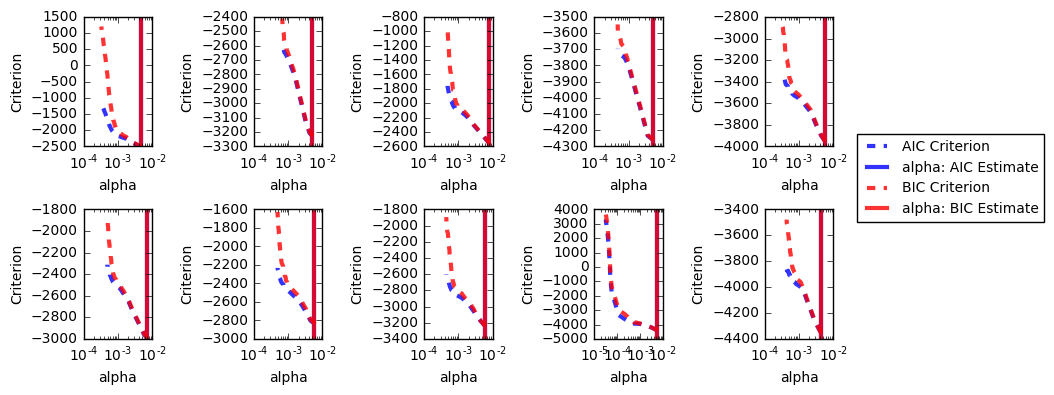

In [25]:
%matplotlib inline
import itertools
import matplotlib.pyplot as plt

def plot_ic_criterion(ax, model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
#     ax.plot(-np.log10(alphas_), criterion_, '--', color=color,
#              linewidth=3, label='%s Criterion' % name)
#     ax.axvline(-np.log10(alpha_), color=color, linewidth=3,
#                 label='alpha: %s Estimate' % name)
#     ax.set_xlabel('-log(alpha)')

    ax.plot(alphas_, criterion_, '--', color=color,
             linewidth=3, label='%s Criterion' % name, alpha=0.8)
    ax.axvline(alpha_, color=color, linewidth=3,
                label='alpha: %s Estimate' % name, alpha=0.8)
    ax.set_xlabel('alpha')
    ax.set_xscale('log', basex=10)
    
    ax.set_ylabel('Criterion')


idx, fig_num, row = 0, len(aic_models), 2
col = int(np.ceil(1.0 * fig_num / row))

fig, axes = plt.subplots(nrows=row, ncols=col, sharex=False, sharey=False, figsize=(10, 4), dpi=400)
for k, (i, j) in list(enumerate(itertools.product(range(row), range(col))))[:fig_num]:
    ax = axes[i, j]
    plot_ic_criterion(ax, aic_models[k], 'AIC', 'b')
    plot_ic_criterion(ax, bic_models[k], 'BIC', 'r')

# fig = plt.figure(figsize=(10, 5), dpi=400)
# for i in xrange(fig_num):
#     ax = fig.add_subplot(*[row, col, i+1])
#     plot_ic_criterion(ax, aic_models[i], 'AIC', 'b')
#     plot_ic_criterion(ax, bic_models[i], 'BIC', 'r')

box = ax.get_position()
ax.set_position([box.x1, box.y0, box.width, box.height])
ax.legend(loc='lower left', bbox_to_anchor=(1.25, 0.85), fontsize=5, prop={'size':10})
# fig.suptitle('Information Criterion for LASSO Model Selection', fontsize=12)
plt.tight_layout()

# Train LASSO Model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import MultiTaskLasso, Lasso
selected_criteria = aic_attributes
coef_lasso_ = np.array([Lasso(alpha=alpha).fit(X, y).coef_ for y, alpha in zip(Y.T, selected_criteria['alpha_'])])
coef_multi_task_lasso_ = MultiTaskLasso(alpha=np.mean(selected_criteria['alpha_'])).fit(X, Y).coef_

print 'LASSO model select %i from %i features.' % (len(set(np.where(coef_lasso_ != 0)[1])), coef_lasso_.shape[1])
print 'Multi-task LASSO model select %i from %i features.' % (len(set(np.where(coef_multi_task_lasso_ != 0)[1])), coef_multi_task_lasso_.shape[1])

# Select features based on the coeffecients and save the data

In [10]:
from bionlp.util import func

idx = np.where(coef_lasso_!=0)
lasso_features = [[] for x in range(coef_lasso_.shape[0])]
for i, j in zip(idx[0], idx[1]):
    lasso_features[i].append(X_df.columns[j]) 
lasso_feature_set = list(set(func.flatten_list(lasso_features)))
lasso_X = X_df[lasso_feature_set]
io.write_df(lasso_X, '../data/chmannot/lasso_X.npz', with_idx=True, sparse_fmt='csr')

idx = np.where(coef_multi_task_lasso_!=0)
mltsk_lasso_features = [[] for x in range(coef_multi_task_lasso_.shape[0])]
for i, j in zip(idx[0], idx[1]):
    mltsk_lasso_features[i].append(X_df.columns[j]) 
mltsk_lasso_feature_set = list(set(func.flatten_list(mltsk_lasso_features)))
mltsk_lasso_X = X_df[mltsk_lasso_feature_set]
io.write_df(mltsk_lasso_X, '../data/chmannot/mltsk_lasso_X.npz', with_idx=True, sparse_fmt='csr')

# Plot the sparsity pattern of the LASSO coefficients

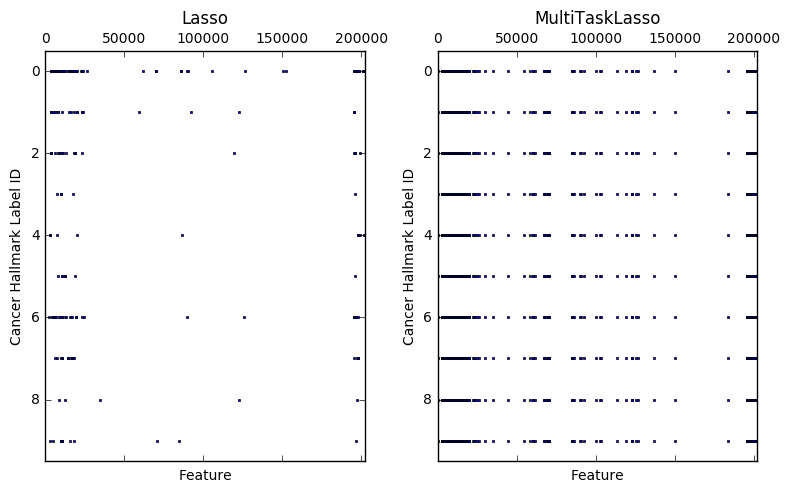

In [18]:
%matplotlib inline
fig = plt.figure(figsize=(8, 5), dpi=400)

ax = plt.subplot(1, 2, 1)
plt.spy(coef_lasso_, markersize=2, aspect='auto')
plt.xlabel('Feature')
plt.ylabel('Cancer Hallmark Label ID')
plt.title('Lasso')

ax = plt.subplot(1, 2, 2)
plt.spy(coef_multi_task_lasso_, markersize=2, aspect='auto')
plt.xlabel('Feature')
plt.ylabel('Cancer Hallmark Label ID')
plt.title('MultiTaskLasso')

plt.tight_layout()
# fig.suptitle('Coefficient non-zero location')
# fig.get_axes()[0].annotate('Coefficient non-zero location', (0.5, 0.95), xycoords='figure fraction', ha='center', fontsize=14)

In [14]:
new_X = io.read_df('../data/chmannot/u100dt500filt_orig_X.npz', with_idx=True, sparse_fmt='csc')
new_feature_set = set(new_X.columns.tolist())
print 'LASSO feature selection overlap: ' + ', '.join(['%.2f%%' % (10 * p) for p in [1.0*len(set(x) & new_feature_set)/len(x) for x in lasso_features]])
print 'LASSO feature selection overlap: ' + ', '.join(['%.2f%%' % (10 * p) for p in [1.0*len(set(x) & new_feature_set)/len(x) for x in mltsk_lasso_features]])

LASSO feature selection overlap: 4.59%, 5.24%, 4.74%, 6.67%, 4.44%, 6.25%, 7.24%, 4.71%, 8.00%, 5.71%
LASSO feature selection overlap: 3.72%, 3.72%, 3.72%, 3.72%, 3.72%, 3.72%, 3.72%, 3.72%, 3.72%, 3.72%


# Calculate the correlation coefficient of the input features

In [2]:
from bionlp.util import math as imath

pr = imath.PearsonR(X.T, sparse_output=True, cache_path='../data/cache')
corrcoef = pr.corrcoef

print 'The correlation coefficient among the features is: %s' % str(corrcoef.shape)
# io.write_spmt(corrcoef, 'corrcoef', sparse_fmt='csr', compress=True)

The correlation coefficient among the features is: (202168, 202168)


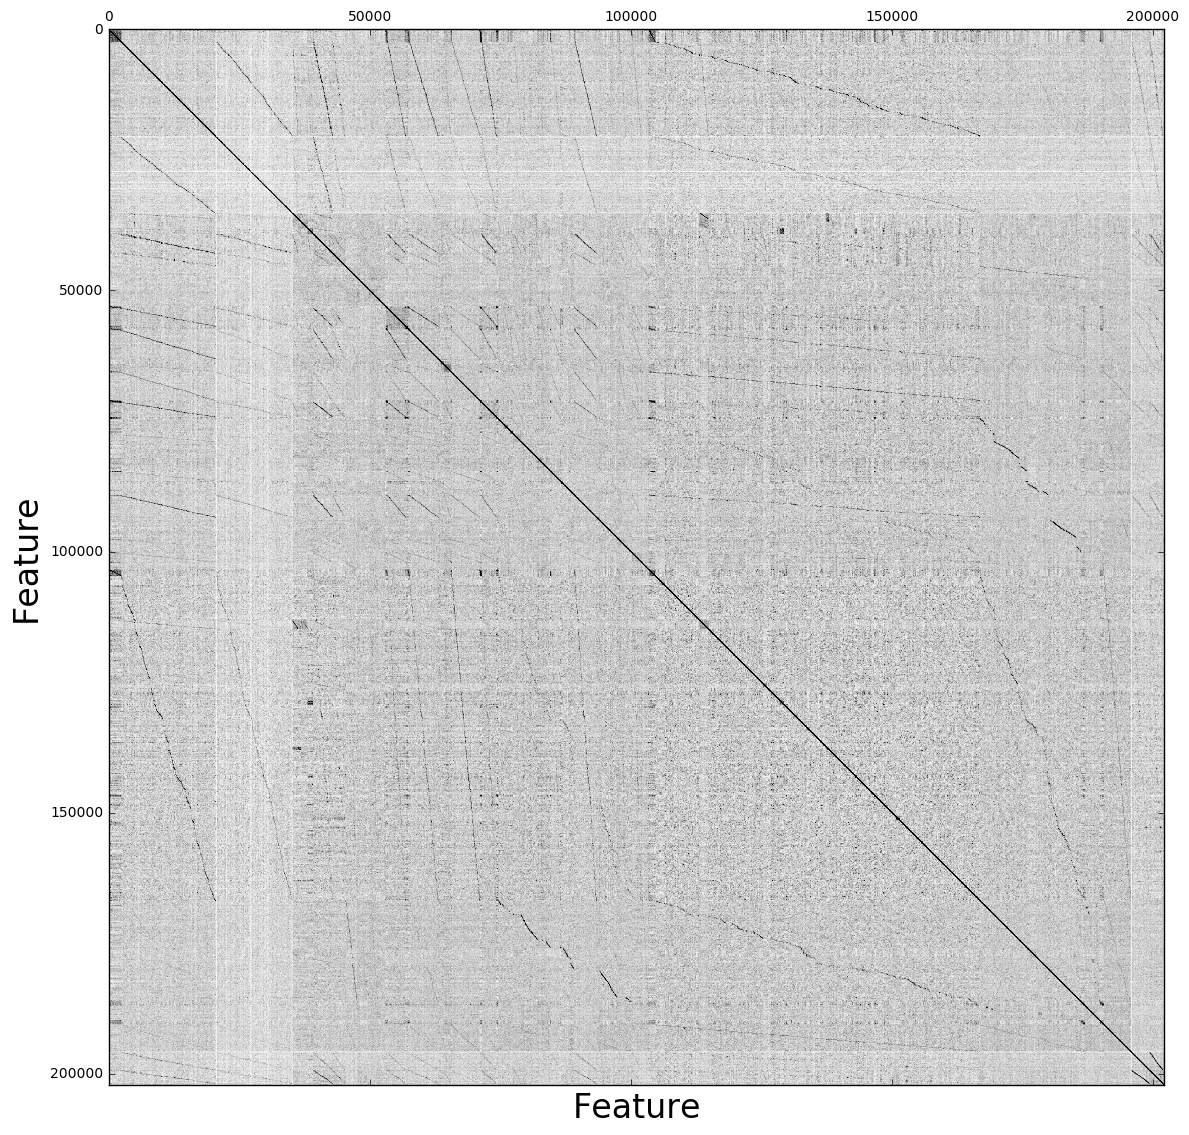

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12), dpi=400)
plt.spy(corrcoef, precision=0.5, aspect='equal', markersize=0.05, color='black', markeredgewidth=0.0)
plt.xlabel('Feature', fontsize=24)
plt.ylabel('Feature', fontsize=24)
# plt.title('Pearson Correlation Coefficient')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,12))
plt.imshow(corrcoef.todense(), interpolation='none', cmap='Blues')
plt.colorbar()
plt.xlabel('Feature', fontsize=24)
plt.ylabel('Feature', fontsize=24)
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,12))
plt.pcolor(corrcoef.todense(), cmap='Blues', edgecolors='None')
plt.colorbar()
plt.xlabel('Feature', fontsize=24)
plt.ylabel('Feature', fontsize=24)
plt.tight_layout()